In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

(720, 1280, 3)


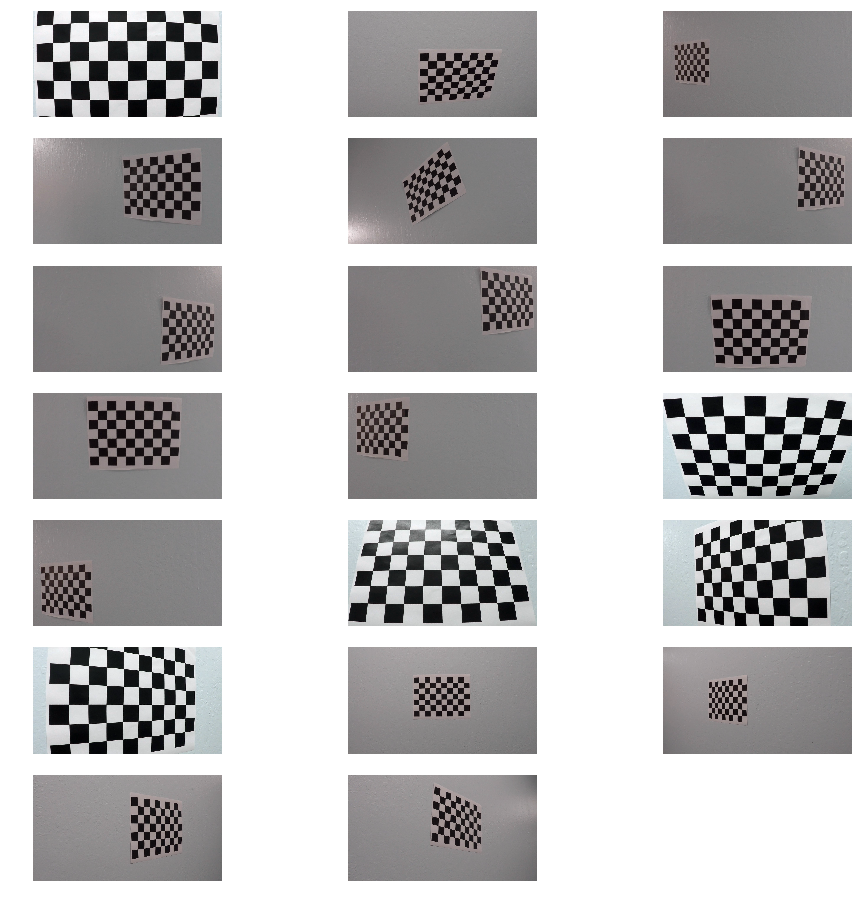

In [2]:
#read the files and display the original images
def read_files(flag):
    images = glob.glob("./camera_cal/*.jpg")
    fig = plt.figure(figsize=(16,16))
    images_list =[]
    i=1
    for fname in images:
        img = cv2.imread(fname)
        images_list.append(img)
        if flag:
            fig.add_subplot(7,3,i)
            plt.imshow(img)
            plt.axis("off")
            i+=1
    if (flag):
        fig.savefig("./output_images/originalimages.jpg")    
        print (img.shape)
    return (images_list)
img_lst = read_files(1)

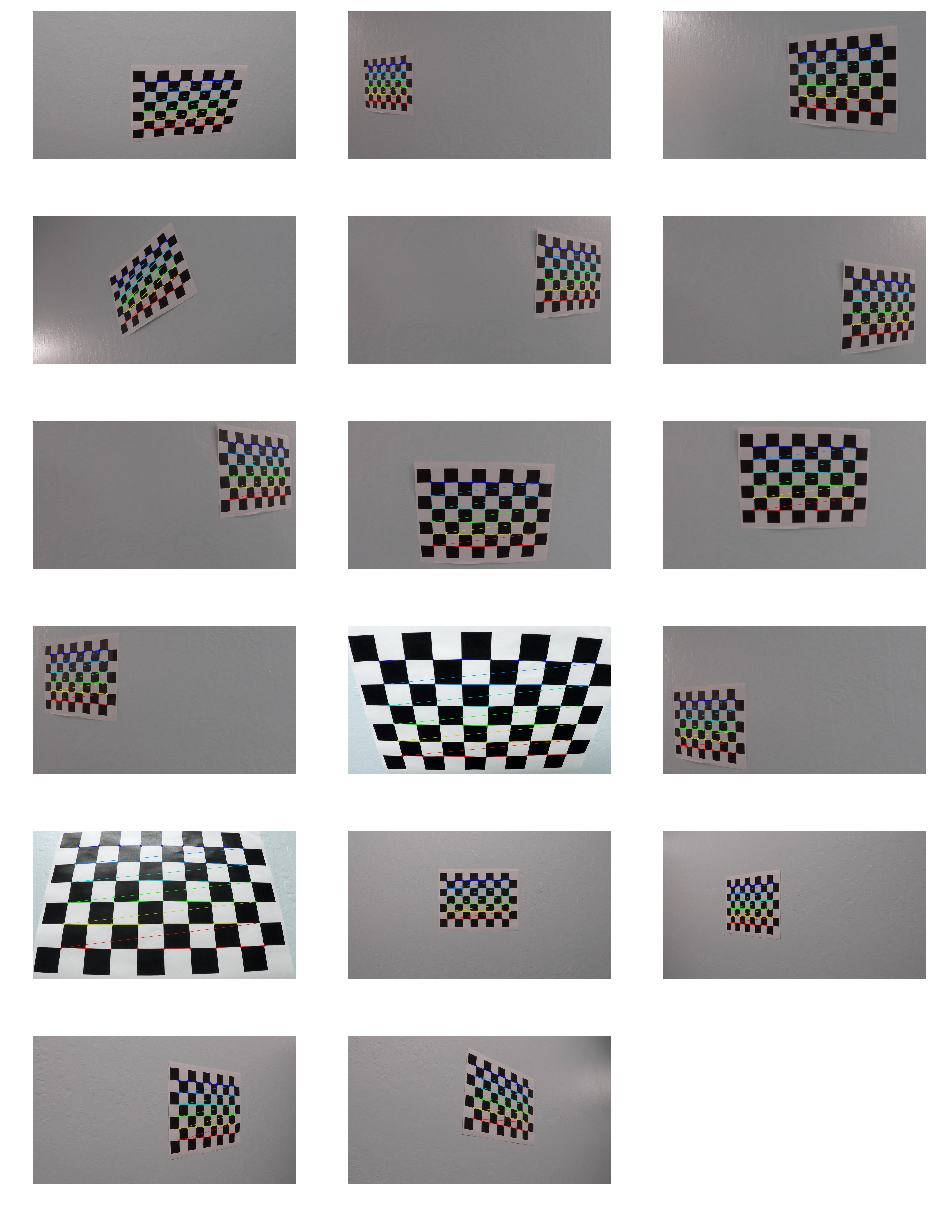

In [3]:
# prepare object points and findChessBoardcorners
def find_drawChessBoardcorners(image_list,flag):
    nx = 9#the number of inside corners in x
    ny = 6#number of inside corners in y
    objpoints=[] #3D points
    imgpoints=[] #2D points
    #prepare object points
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    fig = plt.figure(figsize=(16,22))
    i=1
    # Make a list of calibration images
    for img in img_lst:
    # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
        if ret == True:
        # Draw and display the corners
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            if flag:
                fig.add_subplot(6,3,i)
                plt.imshow(img)
                plt.axis("off")
                i+=1
    if flag:
        fig.savefig("./output_images/drawboardcorners.jpg")
    return(objpoints,imgpoints,gray)
img_lst = read_files(0)
o,i,g = find_drawChessBoardcorners(img_lst,1)

In [4]:
#calibrate the camera
def calibrate_camera(obj,img,gray):
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(obj,img,gray.shape[::-1],None,None)
    return (mtx,dist)

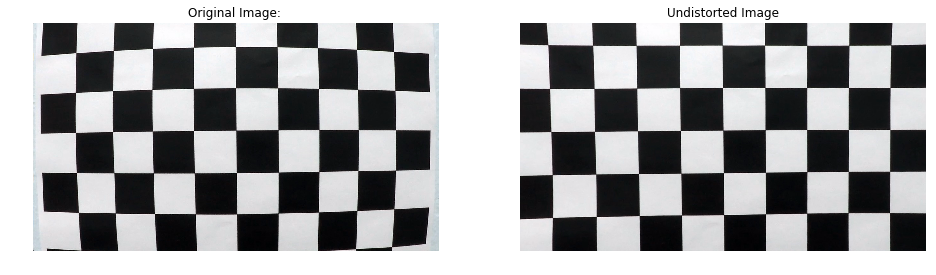

In [27]:
#distortion correction
def distort_corr(img,mtx,dist):
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    return (dst)

#check 
img_lst = read_files(0)
o,i,g = find_drawChessBoardcorners(img_lst,0)
m,d = calibrate_camera(o,i,g)

im = cv2.imread('./camera_cal/calibration1.jpg')
fig = plt.figure(figsize=(16,32))
fig.add_subplot(1,2,1)
plt.title("Original Image: ")
plt.imshow(im)
plt.axis("off")
dst = distort_corr(im,m,d)
fig.add_subplot(1,2,2)
plt.title("Undistorted Image")
plt.imshow(dst)
plt.axis("off")

fig.savefig("./output_images/undistimages.jpg")


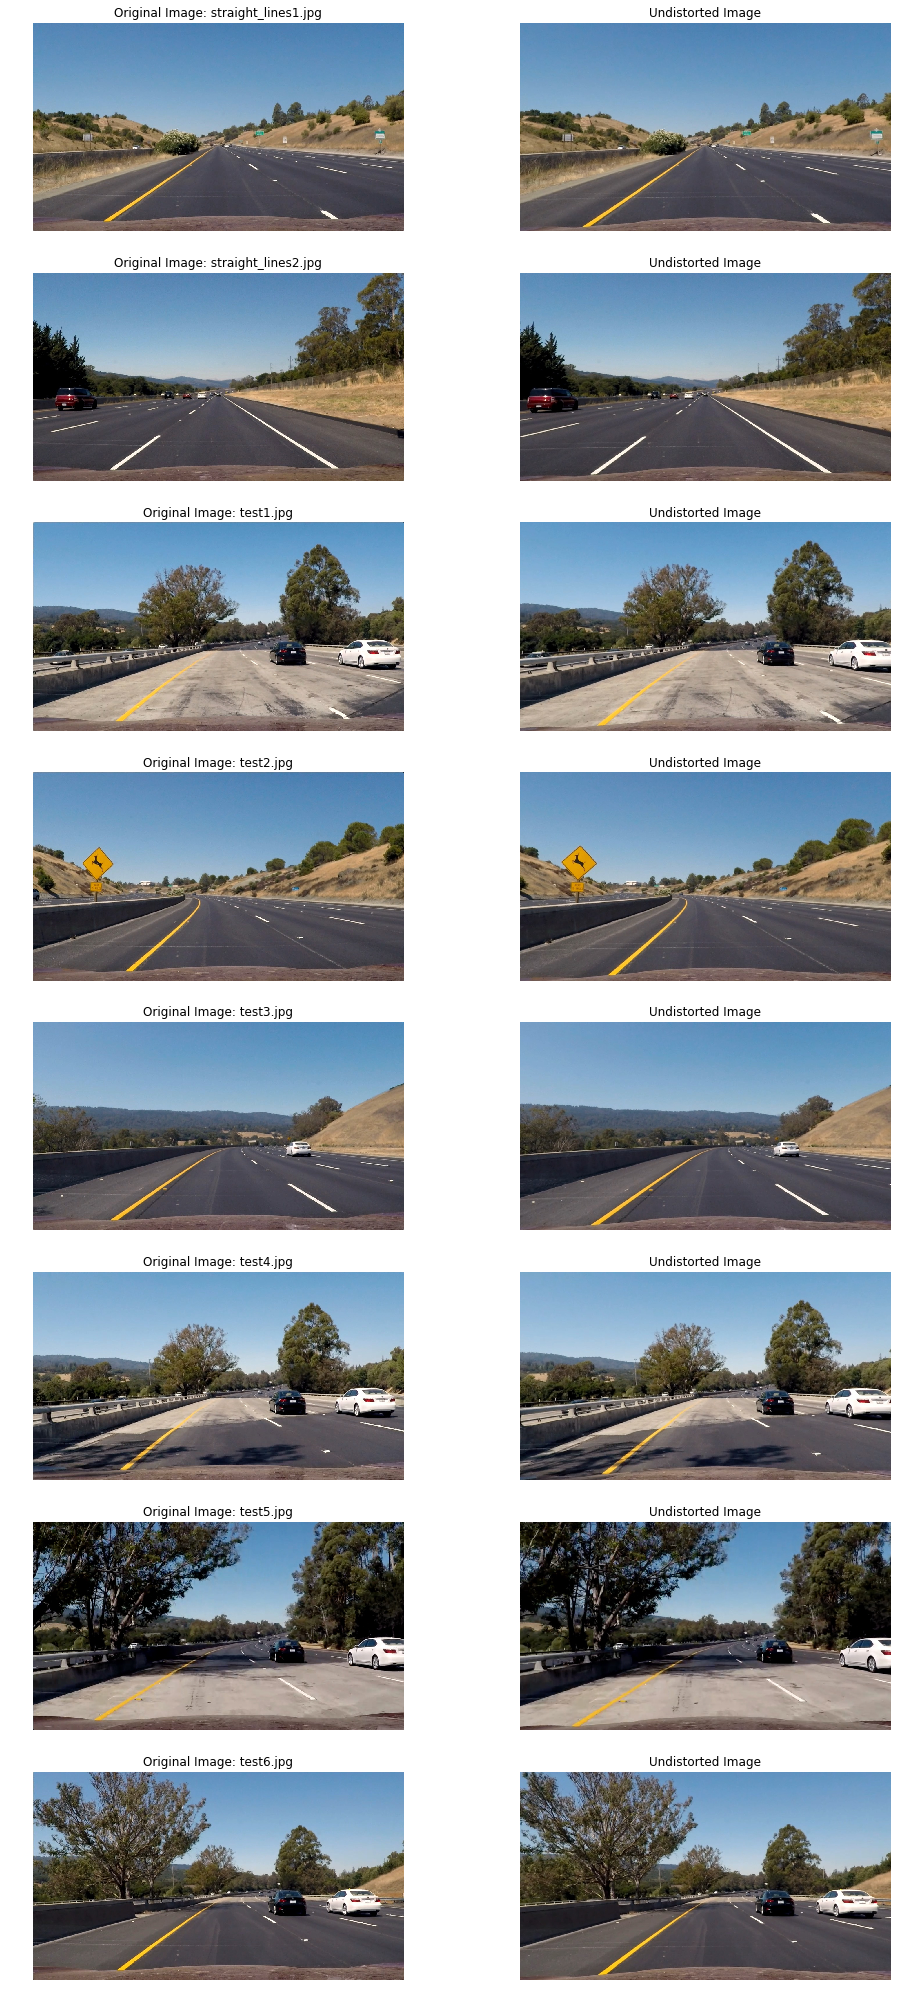

In [6]:
#now test for distort correction on the test files
img_lst = read_files(0)
img_test_lst = glob.glob("./test_images/*.jpg")
o,i,g = find_drawChessBoardcorners(img_lst,0)
m,d = calibrate_camera(o,i,g)

fig = plt.figure(figsize=(16,36))
i=1

for im in img_test_lst:
    img = cv2.imread(im)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig.add_subplot(8,2,i)

    plt.title("Original Image: "+im.split('\\')[-1])
    plt.imshow(img)
    plt.axis("off")
    dst = distort_corr(img,m,d)
    i+=1
    fig.add_subplot(8,2,i)
    plt.title("Undistorted Image")
    plt.imshow(dst)
    plt.axis("off")
    i+=1

fig.savefig("./output_images/undistorted.jpg")


In [7]:
#apply color threshold for rgb, hls, hsv
def color_threshold(img,sthresh=(0,255),rthresh=(0,255),gthresh=(0,255),lthresh=(0,255),vthresh=(0,255)):
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= rthresh[0]) & (r_channel <= rthresh[1])]=1
    
    g_channel = img[:,:,1]
    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel >= gthresh[0]) & (g_channel <= gthresh[1])] = 1
             
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]    
    s_binary=np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    l_channel = hls[:,:,1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= lthresh[0]) & (l_channel <= lthresh[1])] = 1
    
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary=np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1 
    
    
    output = np.zeros_like(s_channel)
    output[((((r_binary ==1) & (g_binary == 1)) |((s_binary == 1) & (v_binary == 1))) & (l_binary == 1))] = 1
    
    return output

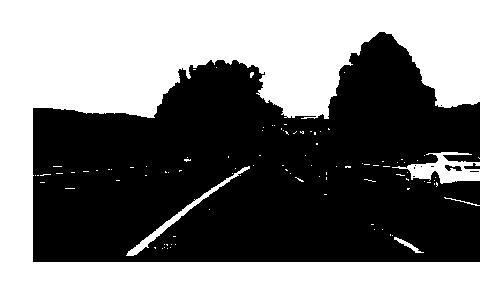

In [30]:
image = cv2.imread("./test_images/test1.jpg")
img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(8,10))
plt.imshow(img)
plt.axis("off")
dst = distort_corr(img,m,d)
c_binary = color_threshold(dst,sthresh=(100,255),rthresh=(200,255),gthresh=(200,255),lthresh=(100,255),vthresh=(100,255))
plt.imshow(c_binary,cmap='gray')
fig.savefig("./output_images/colorthresh.jpg")

In [8]:
#apply perspective transform to the undistorted image
def warp(dst):
    src_pts=np.float32([[570,470],[730,470],[1120,720],[220,720]])
    dst_pts=np.float32([[340,0],[980,0],[980,720],[340,720]])

    image = np.zeros_like(dst[:,:,0])
    c_binary = color_threshold(dst,sthresh=(100,255),rthresh=(200,255),gthresh=(200,255),lthresh=(100,255),vthresh=(100,255))
    image[(c_binary == 1)] = 255
    M = cv2.getPerspectiveTransform(src_pts,dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts,src_pts)
    img_size = (dst.shape[1],dst.shape[0])
    warped = cv2.warpPerspective(image,M,img_size,flags=cv2.INTER_LINEAR)

    return (warped,Minv)
        

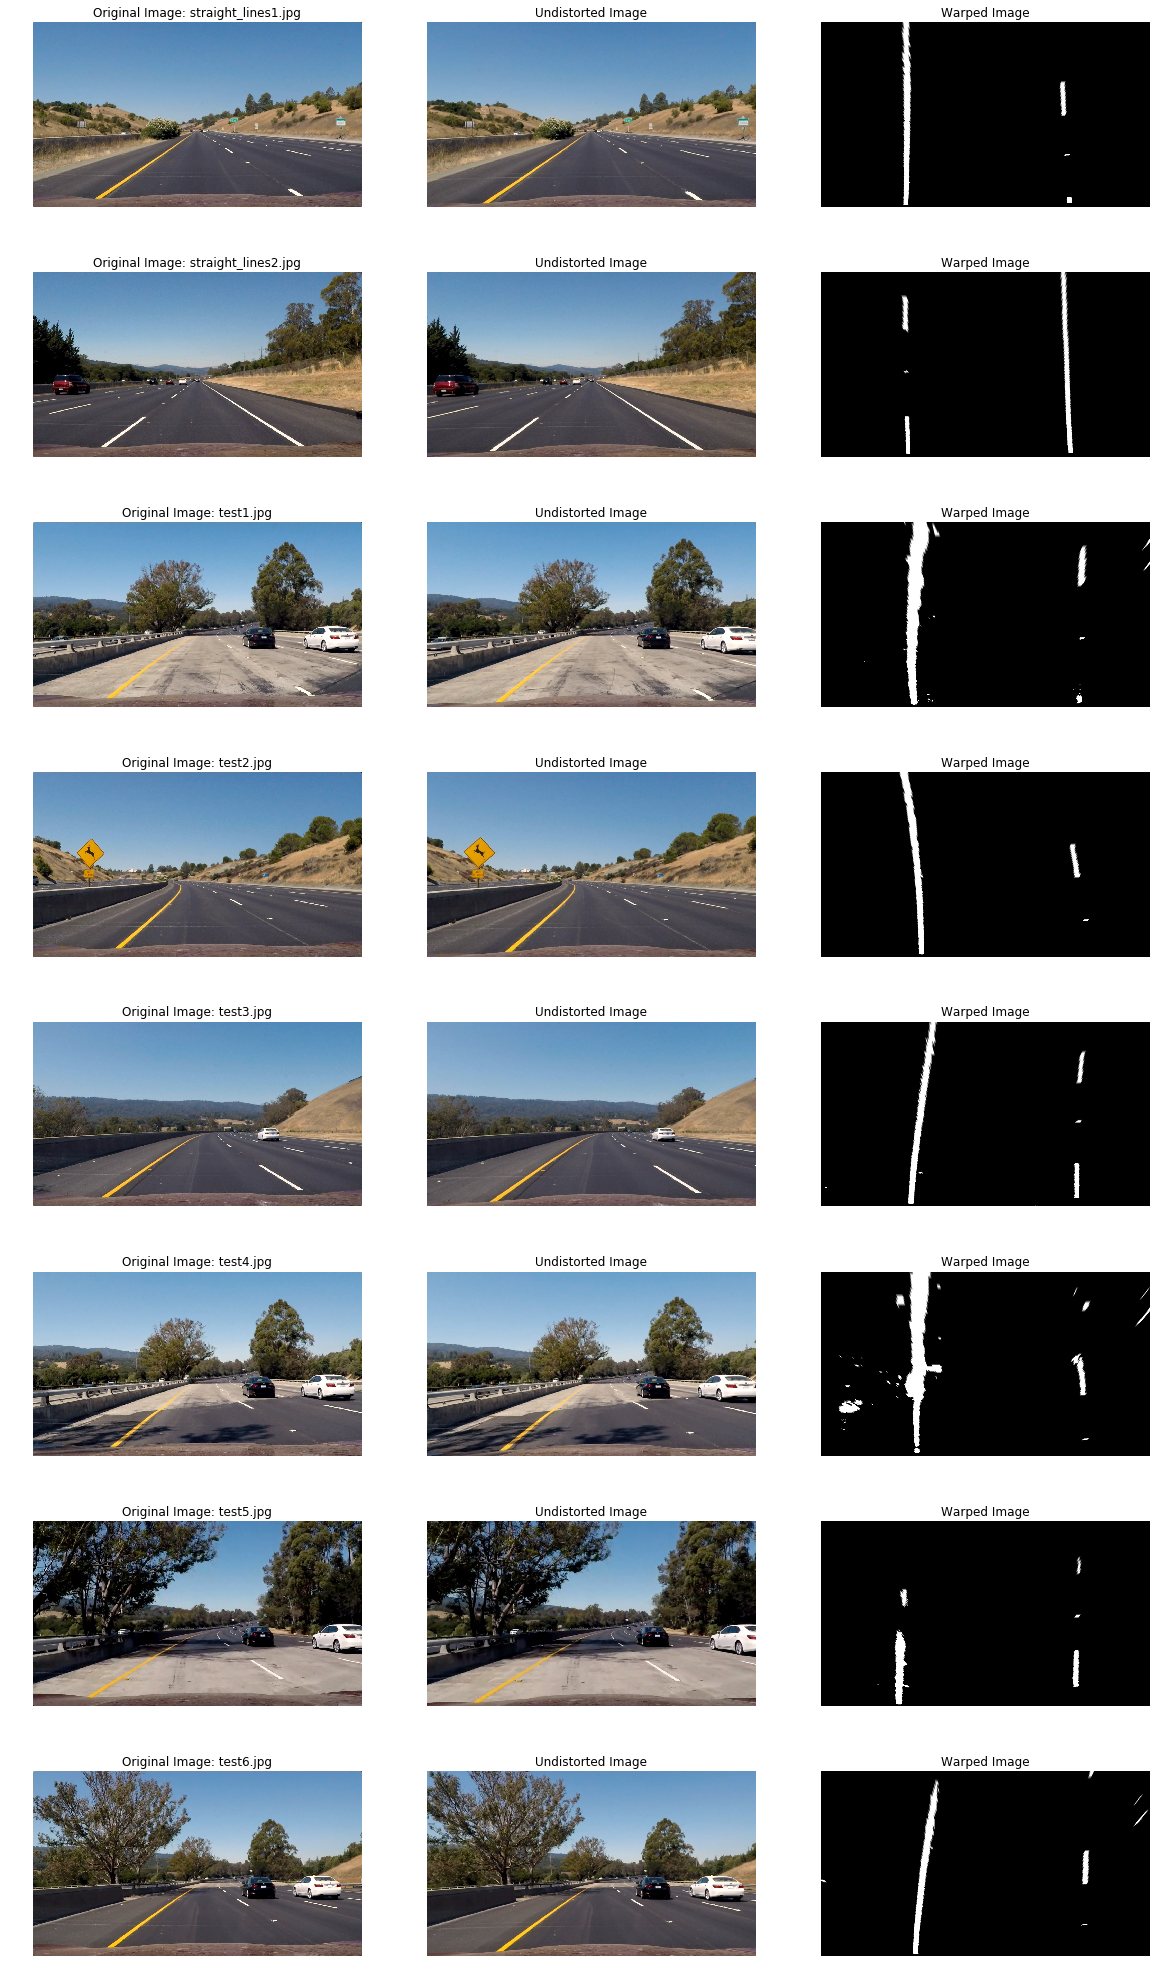

In [9]:
#check the new warped images
img_lst = read_files(0)
img_test_lst = glob.glob("./test_images/*.jpg")
o,i,g = find_drawChessBoardcorners(img_lst,0)
m,d = calibrate_camera(o,i,g)

fig = plt.figure(figsize=(20,36))
i=1

for im in img_test_lst:
    img = cv2.imread(im)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig.add_subplot(8,3,i)

    plt.title("Original Image: "+im.split('\\')[-1])
    plt.imshow(img)
    plt.axis("off")
    dst = distort_corr(img,m,d)
    i+=1
    fig.add_subplot(8,3,i)
    plt.title("Undistorted Image")
    plt.imshow(dst)
    plt.axis("off")
    warped,Minv = warp(dst)
    i+=1
    fig.add_subplot(8,3,i)
    plt.title("Warped Image")
    plt.imshow(warped,cmap='gray')
    plt.axis("off")
    i+=1
fig.savefig("./output_images/warpedimages.jpg")

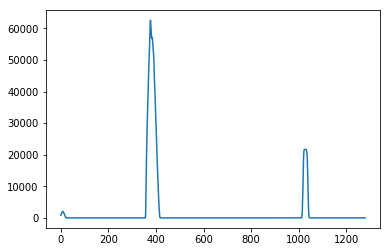

In [10]:
#histogram along the columns of the lower half of image
def hist(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    return (histogram)

histogram = hist(warped)
plt.plot(histogram)

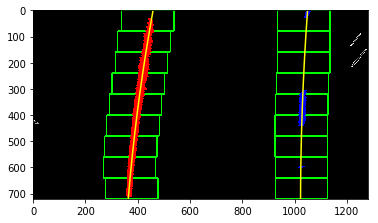

In [21]:
# this function locates the lane lines using sliding windows and fits a polynomial
def fit_line(warped):
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = hist(warped)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    #   Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return (left_fit,right_fit,out_img,left_lane_inds,right_lane_inds,nonzeroy,nonzerox)

def plot_line(left_fit,right_fit,out_img,left_lane_inds,right_lane_inds,nonzeroy,nonzerox):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    fig = plt.figure(figsize=(6,10))
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    fig.savefig("./output_images/polylinerectangles.jpg")
    return

left_fit,right_fit,o_i,l_l,r_l,n_y,n_x = fit_line(warped)
plot_line(left_fit,right_fit,o_i,l_l,r_l,n_y,n_x)

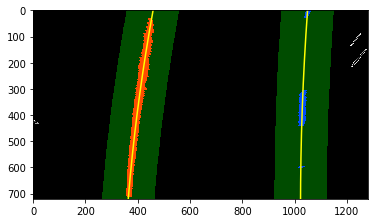

In [24]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def fit_newline(warped,left_fit,right_fit):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return (result,left_fitx,right_fitx,ploty)

def plot_newline(result,left_fitx,right_fitx,ploty):
    fig = plt.figure(figsize=(6,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    fig.savefig("./output_images/polylinenew.jpg")
    
r,left_fitx,right_fitx,ploty = fit_newline(warped,left_fit,right_fit)
plot_newline(r,left_fitx,right_fitx,ploty)


In [13]:
#calculate the radius of curvature of the lane in meters
def radius_curvature(xvalues):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    yvalues = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(yvalues)
    # Fit new polynomials to x,y in world space    
    fit_cr = np.polyfit(yvalues*ym_per_pix, xvalues*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    # radius of curvature is in meters
    return(curverad)


In [14]:
#get the average of the left and right curvature
def avg_rad_cur(left_fitx,right_fitx):
    left_curverad = radius_curvature(left_fitx)
    right_curverad = radius_curvature(right_fitx)
    avg_curverad = (left_curverad + right_curverad)/2
    return (avg_curverad)


In [15]:
#calculate the center offset
def center_offset(warped,left_fitx,right_fitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    camera_position = warped.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(camera_position - lane_center)
    center_offset_m = center_offset_pixels * xm_per_pix
    return (center_offset_m)


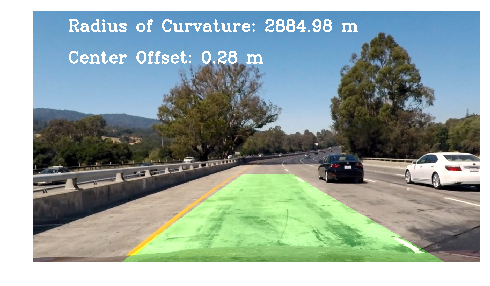

In [31]:

#def final_image(warped,left_fitx,right_fitx,ploty):
def final_image(dst,warped,Minv):
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = hist(warped)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    #   Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #return (left_fit,right_fit,out_img,left_lane_inds,right_lane_inds,nonzeroy,nonzerox)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]          
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)
    c_offset = center_offset(warped,left_fitx,right_fitx)
    r_curvature = avg_rad_cur(left_fitx,right_fitx)
    cv2.putText(result,"Radius of Curvature: %.2f m" % r_curvature,(100,60),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,255,255),3)
    cv2.putText(result, "Center Offset: %.2f m" % c_offset, (100, 150), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255,255,255), 3)
    
    return (result)
fig = plt.figure(figsize=(8,10))
result = final_image(dst,warped,Minv)
plt.imshow(result)
plt.axis("off")
fig.savefig("./output_images/final.jpg")

In [26]:
img_lst = read_files(0)
img_test_lst = glob.glob("./test_images/*.jpg")
o,i,g = find_drawChessBoardcorners(img_lst,0)
m,d = calibrate_camera(o,i,g)

def advanced_lane_pipeline(image):
    dst = distort_corr(image,m,d)
    warped,Minv = warp(dst)
    result = final_image(dst,warped,Minv)
    return result
 
    


In [18]:
from moviepy.editor import VideoFileClip
video_output = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(advanced_lane_pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:28<00:00,  8.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 29s
